<a href="https://colab.research.google.com/github/farahshahhoud/Machine_Learning/blob/master/Labratory5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Цель лабораторной работы:
изучение линейных моделей, SVM и деревьев решений.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

#Набор данных
Наш набор данных с веб-сайта https://archive.ics.uci.edu/ml/datasets.php. Набор данных относится к клиентам оптового дистрибьютора. Он включает ежегодные расходы в денежных единицах (млн. Ед.) На различные товарные категории. Мы будем использовать столбцы набора данных для классификации признак "Channel".

In [0]:
data=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')

In [4]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
data.shape

(440, 8)

In [6]:
data.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [7]:
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [8]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

База данных не содержит отсутствующих переменных или переменных категории. Мы можем работать с набором данных напрямую.

In [9]:
np.unique(data.Channel)

array([1, 2])

Классы классификации состоят только из двух значений (1 или 2)

#Разделите выборку на обучающую и тестовую

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data[[ 'Region', 'Fresh',
                      'Milk', 'Grocery', 'Frozen',
                  'Detergents_Paper', 'Delicassen']], data['Channel'],
                   test_size=0.7, random_state=3)

In [0]:
target=data[['Channel']]

In [0]:
dataOnly=data[[ 'Region', 'Fresh',
                      'Milk', 'Grocery', 'Frozen',
                  'Detergents_Paper', 'Delicassen']]

In [13]:
X_train.shape, y_train.shape

((132, 7), (132,))

In [14]:
X_test.shape, y_test.shape

((308, 7), (308,))

In [15]:
np.unique(y_train)

array([1, 2])

In [16]:
np.unique(y_test)

array([1, 2])

#Обучиние

Сначала давайте посмотрим, сколько значений в каждом классе.

In [0]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [18]:
print_class_proportions(data.Channel)

Метка 	 Количество 	 Процент встречаемости
1 	 298 	 	 67.73%
2 	 142 	 	 32.27%


Таким образом, в наборе данных есть небольшой уклон (bias)

##Оценка качества моделей 

для оценки качества каждого классификатора. Мы будем использовать precision, recall, f1 и Roc Auc.   
В дополнение к этому мы увидим оценку точности для двух классов отдельно.

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show() 

In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [0]:
labels=[1,2]

##модели классификаторов

In [0]:
from sklearn import svm
clas_models = { 'LR': LogisticRegression(),
               'SVC':svm.SVC(decision_function_shape='ovo'),
               'Tree':DecisionTreeClassifier()}

In [0]:
clasMetricLogger = MetricLogger()

In [0]:
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(y_test, Y_pred)
    precision = precision_score(y_test.values, Y_pred)
    recall = recall_score(y_test.values, Y_pred)
    f1 = f1_score(y_test.values, Y_pred)
    roc_auc = roc_auc_score(y_test.values, Y_pred)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    
    draw_roc_curve(y_test.values, Y_pred)
    
    plot_confusion_matrix(model,X_test, y_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

Метка 	 Accuracy
1 	 0.9306930693069307
2 	 0.8207547169811321
*****************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


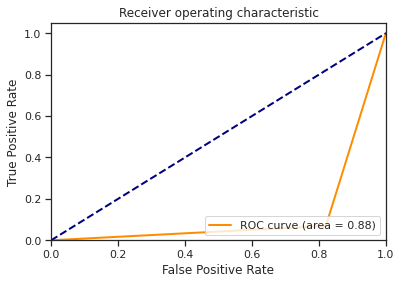

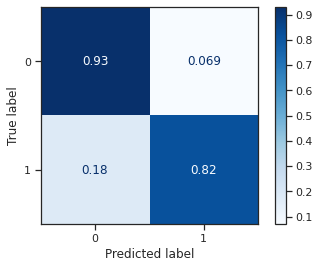

Метка 	 Accuracy
1 	 0.900990099009901
2 	 0.8113207547169812
*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


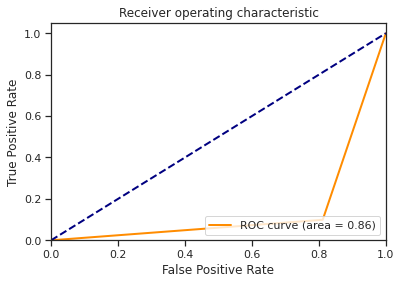

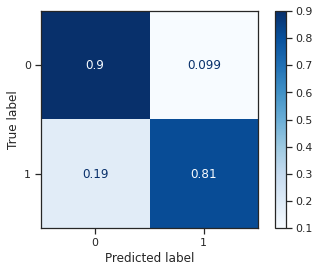

Метка 	 Accuracy
1 	 0.8861386138613861
2 	 0.8301886792452831
*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************


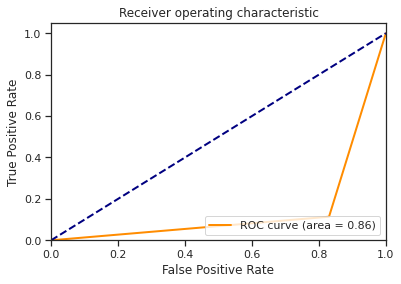

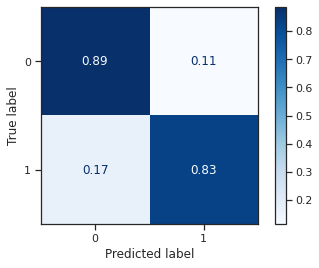

In [26]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [0]:
clas_metrics = clasMetricLogger.df['metric'].unique()

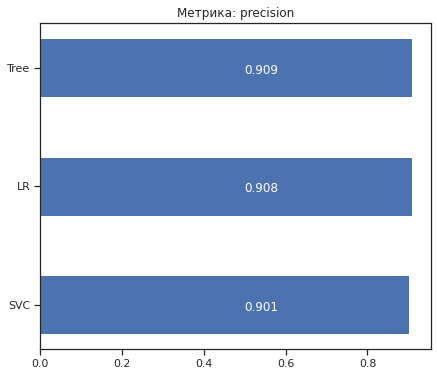

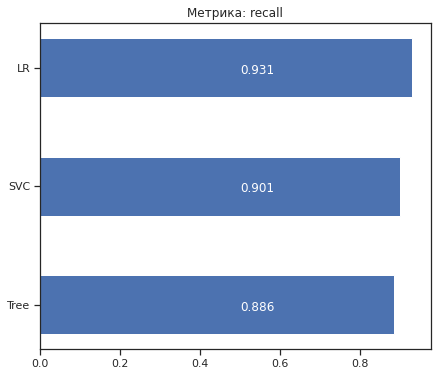

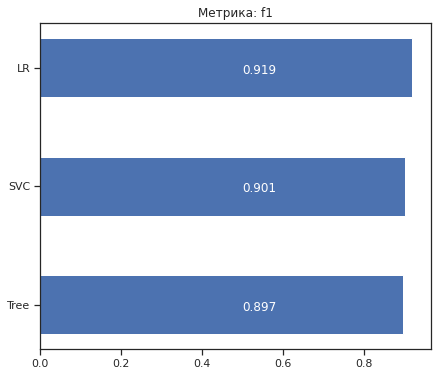

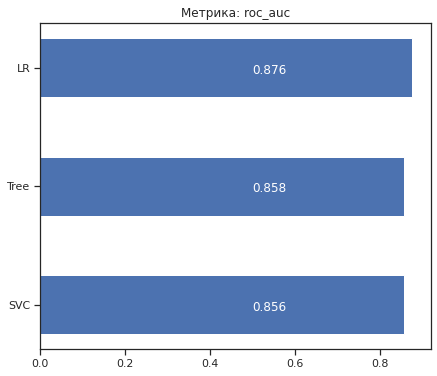

In [28]:
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

##Grid Search для Logistic Regression:

In [0]:
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')

In [30]:
grid_clf_acc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [31]:
grid_clf_acc.best_estimator_

LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
grid_clf_acc.best_params_

{'C': 0.09, 'penalty': 'l2'}

In [0]:
clas_models_grid = {'LR_0.09_12':grid_clf_acc.best_estimator_}

Метка 	 Accuracy
1 	 0.9306930693069307
2 	 0.8301886792452831
*****************************************************
LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


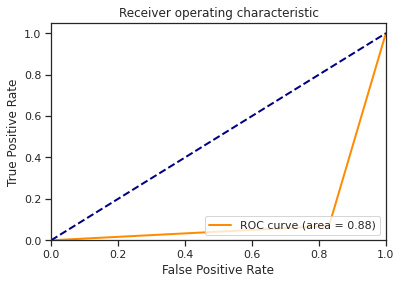

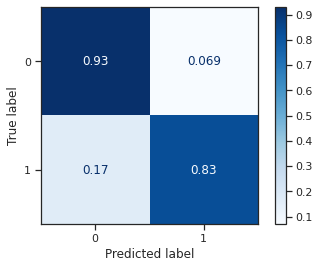

In [34]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

##Grid Search для SVC:

In [0]:
param_grid = {'gamma':[1,0.1], 'kernel':['linear','rbf']}

In [36]:
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] gamma=1, kernel=linear ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................... gamma=1, kernel=linear, total=  18.6s
[CV] gamma=1, kernel=linear ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


[CV] ........................... gamma=1, kernel=linear, total=  16.4s
[CV] gamma=1, kernel=linear ..........................................
[CV] ........................... gamma=1, kernel=linear, total=  46.2s
[CV] gamma=1, kernel=linear ..........................................
[CV] ........................... gamma=1, kernel=linear, total= 1.3min
[CV] gamma=1, kernel=linear ..........................................
[CV] ........................... gamma=1, kernel=linear, total= 1.5min
[CV] gamma=1, kernel=rbf .............................................
[CV] .............................. gamma=1, kernel=rbf, total=   0.0s
[CV] gamma=1, kernel=rbf .............................................
[CV] .............................. gamma=1, kernel=rbf, total=   0.0s
[CV] gamma=1, kernel=rbf .............................................
[CV] .............................. gamma=1, kernel=rbf, total=   0.0s
[CV] gamma=1, kernel=rbf .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [1, 0.1], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [37]:
grid.best_estimator_

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
grid.best_params_

{'gamma': 1, 'kernel': 'linear'}

In [0]:
clas_models_grid = {'SVM':grid.best_estimator_}

Метка 	 Accuracy
1 	 0.8910891089108911
2 	 0.839622641509434
*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


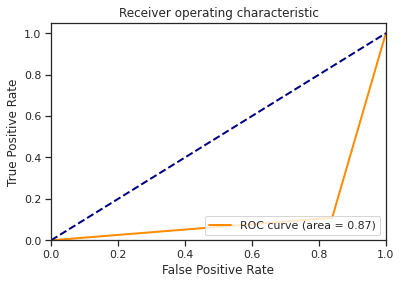

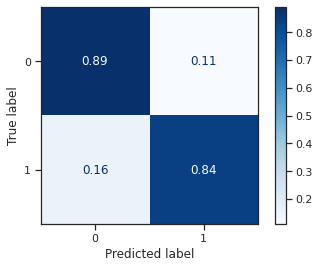

In [40]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

##Grid Search для Decision Tree:

In [41]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3,scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    2.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [42]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [43]:
grid_search_cv.best_params_

{'max_leaf_nodes': 2, 'min_samples_split': 2}

In [0]:
clas_models_grid = {'Tree':grid_search_cv.best_estimator_}

Метка 	 Accuracy
1 	 0.8861386138613861
2 	 0.9433962264150944
*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
*****************************************************


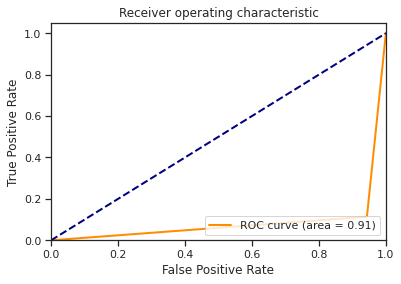

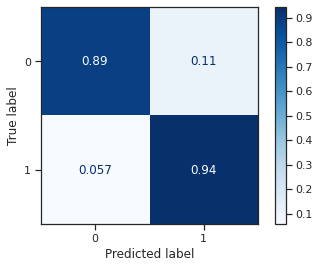

In [45]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [0]:
tree_cl=grid_search_cv.best_estimator_

In [47]:
from sklearn.tree.export import export_text
tree_rules = export_text(tree_cl, feature_names=list(dataOnly.columns))
tree_rules

'|--- Detergents_Paper <= 1759.50\n|   |--- class: 1\n|--- Detergents_Paper >  1759.50\n|   |--- class: 2\n'